# check for TOC

In [3]:
import pymupdf
import os

base_folder = "/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/"

files_with_toc = []
files_without_toc = []

for root, dirs, files in os.walk(base_folder):
    for file in files:
        if file.endswith(".pdf"):
            file_path = os.path.join(root, file)
            doc = pymupdf.open(file_path)
            toc = doc.get_toc()
            if len(toc) > 0:
                files_with_toc.append({"path": file_path, "toc": toc})
            else:
                files_without_toc.append(file_path)
            # print(f"TOC for {file_path}:")
            # print(toc)

In [4]:
len(files_with_toc)

43

In [5]:
len(files_without_toc)

37

# Extract TOC with Markdown

In [6]:
import pymupdf

doc = pymupdf.open("/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf")
toc = doc.get_toc()
# toc

In [7]:
import pandas as pd

def enumerate_toc(hierarchy_levels):
    enumeration = []
    stack = []
    for level in hierarchy_levels:
        # Adjust stack to current level
        while len(stack) > level:
            stack.pop()
        if len(stack) < level:
            stack += [0] * (level - len(stack))
        # Increment current level
        stack[-1] += 1
        # Reset lower levels
        for i in range(level, len(stack)):
            stack[i] = 0
        # Build enumeration string
        enum_str = ".".join(str(num) for num in stack if num > 0)
        enumeration.append(enum_str)
    return enumeration

def generate_markdown_toc(toc):
    toc_df = pd.DataFrame(toc, columns=["hierarchy_level", "title", "page_number"])
    toc_df["enumeration"] = enumerate_toc(toc_df["hierarchy_level"].tolist())
    toc_markdown = toc_df.to_markdown(index=False)
    return toc_markdown

for item in files_with_toc:
    item['n_entries'] = len(item['toc'])
    item['markdown_toc'] = generate_markdown_toc(item['toc'])

files_with_toc

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [9]:
import json

toc_data = {
    "files_with_toc": files_with_toc,
    "files_without_toc": files_without_toc
}

with open("../../benchmark_truth/toc_data.json", "w") as f:
    json.dump(toc_data, f, indent=4)


# Work with the machine readable TOC

In [16]:
pd.DataFrame(toc_data["files_with_toc"][0]['toc'], columns=["hierarchy_level", "title", "page_number"]).to_json(index=False, orient="records")

'[{"hierarchy_level":1,"title":"Lagebericht","page_number":5},{"hierarchy_level":1,"title":"Bilanz","page_number":7},{"hierarchy_level":1,"title":"Gewinn- und Verlustrechnung","page_number":10},{"hierarchy_level":1,"title":"Anhang","page_number":13},{"hierarchy_level":1,"title":"Lagebericht ","page_number":17},{"hierarchy_level":1,"title":"Bilanz","page_number":25},{"hierarchy_level":1,"title":"Anhang","page_number":31},{"hierarchy_level":1,"title":"Anlagenspiegel","page_number":39},{"hierarchy_level":1,"title":"Best\\u00e4tigungsvermerk","page_number":42}]'

In [10]:
toc_markdown = toc_data["files_with_toc"][0]["markdown_toc"]
print(toc_markdown)

|   hierarchy_level | title                       |   page_number |   enumeration |
|------------------:|:----------------------------|--------------:|--------------:|
|                 1 | Lagebericht                 |             5 |             1 |
|                 1 | Bilanz                      |             7 |             2 |
|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |
|                 1 | Anhang                      |            13 |             4 |
|                 1 | Lagebericht                 |            17 |             5 |
|                 1 | Bilanz                      |            25 |             6 |
|                 1 | Anhang                      |            31 |             7 |
|                 1 | Anlagenspiegel              |            39 |             8 |
|                 1 | Bestätigungsvermerk         |            42 |             9 |


In [18]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="sk-1234567890abcdef1234567890abcdef1234567890abcdef1234567890abcdef",
)

models = client.models.list()
model = models.data[0].id
print(f"Using model: {model}")

Using model: mistralai/Ministral-8B-Instruct-2410


## simple request

In [20]:
def combine_messages(messages):
    """
    Combines subsequent dicts in a list with the same 'role' by joining their 'content' strings.
    Args:
        messages (list of dict): Each dict must have 'role' and 'content' keys.
    Returns:
        list of dict: Combined messages.
    """
    if not messages:
        return []

    combined = [messages[0].copy()]
    for msg in messages[1:]:
        if msg["role"] == combined[-1]["role"]:
            combined[-1]["content"] += "\n" + msg["content"]
        else:
            combined.append(msg.copy())
    return combined

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the win and loss statement (in German: Gewinn- und Verlustrechnung) located?"},
    {"role": "assistant", "content": f"The win and loss statement can be found on page "}
]

In [ ]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [16]:
result

'The win and loss statement (Gewinn- und Verlustrechnung) is located on page 10.'

In [22]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page is the balance sheets (in German: Bilanz) located? Give seperate answers for the liabilities and assets table."},
    {"role": "assistant", "content": f"The balance sheet can be found on the pages "}
]

In [23]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [24]:
result

'The balance sheet (Bilanz) is located on the following pages:\n\n- Liabilities and Assets Table: Page 7\n- Liabilities and Assets Table: Page 25'

In [25]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'liabilities', 'assets', and 'win_loss_statement' and the page numbers as values."},
]
combine_messages(messages)

[{'role': 'system',
  'content': 'You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents.'},
 {'role': 'user',
  'content': "This is the table of contents:\n\n|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |             5 |\n|                 1 | Bilanz                      |            25 |             6 |\n|                 1 | Anhang                      |     

In [26]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    # extra_body={
    #     "guided_grammar": ebnf_grammar,
    #     # 'use_beam_search': True
    # },
    max_tokens=1000,
    temperature=0.2,
)

result = completion.choices[0].message.content

In [27]:
result

'{\n  "assets": 7,\n  "liabilities": 7,\n  "win_loss_statement": 10\n}'

## structured generation

In [28]:
from pydantic import BaseModel
# from enum import Enum

# class CarType(str, Enum):
#     sedan = "sedan"
#     suv = "SUV"
#     truck = "Truck"
#     coupe = "Coupe"

class TOCEntry(BaseModel):
    title: str
    page: int

class TOC(BaseModel):
    entries: list[TOCEntry]

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'TOCEntry': {'properties': {'title': {'title': 'Title',
     'type': 'string'},
    'page': {'title': 'Page', 'type': 'integer'}},
   'required': ['title', 'page'],
   'title': 'TOCEntry',
   'type': 'object'}},
 'properties': {'entries': {'items': {'$ref': '#/$defs/TOCEntry'},
   'title': 'Entries',
   'type': 'array'}},
 'required': ['entries'],
 'title': 'TOC',
 'type': 'object'}

In [33]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [34]:
result

'{\n  "entries": [\n    {\n      "title": "Gewinn- und Verlustrechnung",\n      "page": 10\n    },\n    {\n      "title": "Bilanz",\n      "page": 7\n    }\n  ]\n}'

In [35]:
from pydantic import BaseModel


class TOC(BaseModel):
    GuV: int
    Aktiva: int
    Passiva: int

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'GuV': {'title': 'Guv', 'type': 'integer'},
  'Aktiva': {'title': 'Aktiva', 'type': 'integer'},
  'Passiva': {'title': 'Passiva', 'type': 'integer'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [36]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which page are the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page numbers as values."},
]

In [40]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    temperature=0,
)

result = completion.choices[0].message.content


In [41]:
result

'{\n  "GuV": 10,\n  "Aktiva": 7,\n  "Passiva": 7\n}'

### page ranges

In [42]:
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()
json_schema

{'$defs': {'PageRange': {'properties': {'start': {'title': 'Start',
     'type': 'integer'},
    'end': {'title': 'End', 'type': 'integer'}},
   'required': ['start', 'end'],
   'title': 'PageRange',
   'type': 'object'}},
 'properties': {'GuV': {'$ref': '#/$defs/PageRange'},
  'Aktiva': {'$ref': '#/$defs/PageRange'},
  'Passiva': {'$ref': '#/$defs/PageRange'}},
 'required': ['GuV', 'Aktiva', 'Passiva'],
 'title': 'TOC',
 'type': 'object'}

In [43]:
messages = [
    {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
]

In [44]:
completion = client.chat.completions.create(
    model=model,
    messages=combine_messages(messages),
    extra_body={
        "response_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "toc",
                "schema": json_schema
            },
        },
    },
    max_tokens=1000,
    logprobs=1,
    temperature=0,
)

result = completion.choices[0].message.content
logprobs = getattr(completion.choices[0], "logprobs", None)


In [45]:
result

'{\n  "GuV": {\n    "start": 10,\n    "end": 10\n  },\n  "Aktiva": {\n    "start": 7,\n    "end": 7\n  },\n  "Passiva": {\n    "start": 7,\n    "end": 7\n  }\n}'

In [22]:
import numpy as np

def calculate_confidence(log_probs):
    return np.exp(np.sum(log_probs))

# def calculate_confidence_linear_probs(log_probs):
#     linear_probs = np.round(np.exp(log_probs)*100,2)
#     confidence = np.mean(linear_probs)
#     return confidence

In [51]:
# token_logprobs = np.array([t.logprob for t in logprobs.content])
# confidence = calculate_confidence_linear_probs(token_logprobs)
# confidence

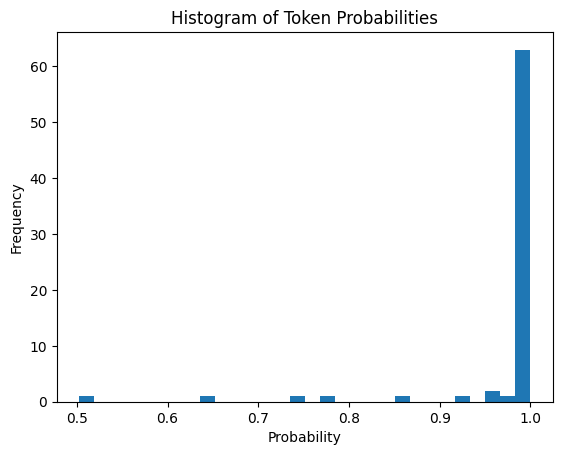

In [48]:
import matplotlib.pyplot as plt

plt.hist(np.exp(token_logprobs), bins=30)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Token Probabilities")
plt.show()

In [52]:
import numpy as np

# Concatenate all tokens to reconstruct the generated text
tokens = [t.token for t in logprobs.content]
generated_text = ''.join(tokens)

# Find logprobs for tokens that are numbers
number_logprobs = []
numbers = []
for t in logprobs.content:
    # Check if the token is a number (integer)
    if t.token.strip().isdigit():
        number_logprobs.append(t.logprob)
        numbers.append(t.token.strip())

[str(number)+": "+str(conf) for conf, number in zip(np.exp(number_logprobs), numbers)]

['1: 0.9850110220817944',
 '0: 0.9943485788648945',
 '1: 0.9783530013961784',
 '0: 0.738269956440733',
 '7: 0.7773805787144588',
 '7: 0.8665902178471487',
 '7: 0.5028879267914775',
 '7: 0.9213157019901284']

In [53]:
tokens_logprobs = [(t.token, t.logprob) for t in logprobs.content]
tokens_logprobs

digit_list = []

for token, logprob in tokens_logprobs:
    if token.strip().isdigit():
        digit_list.append((token, logprob))
    else:
        digit_logprobs = [t[1] for t in digit_list]
        number = [t[0] for t in digit_list]
        if digit_logprobs:
            print(str(number)+": "+str(digit_logprobs))
            confidence = calculate_confidence(np.array(digit_logprobs))
            print(f"Confidence: {confidence}")
        digit_list = []



['1', '0']: [-0.0151024479418993, -0.005667450837790966]
Confidence: 0.9794443099732894
['1', '0']: [-0.021884731948375702, -0.3034457266330719]
Confidence: 0.722288627724417
['7']: [-0.2518252432346344]
Confidence: 0.7773805787144588
['7']: [-0.14318905770778656]
Confidence: 0.8665902178471487
['7']: [-0.6873879432678223]
Confidence: 0.5028879267914775
['7']: [-0.0819525197148323]
Confidence: 0.9213157019901284


In [58]:
grouped_confidences = []
for i in range(0, len(number_logprobs), 2):
    group = number_logprobs[i:i+2]
    confidence = calculate_confidence(np.array(group))
    grouped_confidences.append(confidence)

grouped_confidences

[np.float64(0.9794443099732894),
 np.float64(0.722288627724417),
 np.float64(0.6736704050583053),
 np.float64(0.46331854329425043)]

In [57]:
generated_text

'{ĊĠĠ"GuV":Ġ{ĊĠĠĠĠ"start":Ġ10,ĊĠĠĠĠ"end":Ġ10ĊĠĠ},ĊĠĠ"Aktiva":Ġ{ĊĠĠĠĠ"start":Ġ7,ĊĠĠĠĠ"end":Ġ7ĊĠĠ},ĊĠĠ"Passiva":Ġ{ĊĠĠĠĠ"start":Ġ7,ĊĠĠĠĠ"end":Ġ7ĊĠĠ}Ċ}</s>'

## looping

In [ ]:
import json

def calculate_confidence_for_integers(log_probs):
    tokens_logprobs = [(t.token, t.logprob) for t in log_probs.content]

    digit_list = []
    confidence_scores = []

    for token, logprob in tokens_logprobs:
        if token.strip().isdigit():
            digit_list.append((token, logprob))
        else:
            digit_logprobs = [t[1] for t in digit_list]
            number = [t[0] for t in digit_list]
            if digit_logprobs:
                # print(str(number)+": "+str(digit_logprobs))
                confidence = calculate_confidence(np.array(digit_logprobs))
                # print(f"Confidence: {confidence}")
                # Convert list of digit tokens to a single integer
                number_str = ''.join(number)
                confidence_scores.append({"number": int(number_str), "confidence": confidence})
            digit_list = []

    return confidence_scores

from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()
json_schema

page_range_result = []

for idx, entry in enumerate(files_with_toc):
    print(f"Processing file {idx + 1}/{len(files_with_toc)}:")
    toc_markdown = pd.DataFrame(entry["toc"], columns=["hierarchy_level", "title", "page_number"]).to_markdown(index=False)
    toc_json = pd.DataFrame(entry['toc'], columns=["hierarchy_level", "title", "page_number"]).to_json(index=False, orient="records")

    # messages = [
    #     {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    #     {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
    #     {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    #     {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    #     {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    # ]

    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_markdown}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        # {"role": "user", "content": f"As page range give the starting page of the suitable section and the page before the next section starts. If the section is only one page, give the same number for both start and end page."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        max_tokens=1000,
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["path"]

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result.append(result_json)


Processing file 1/43:
Processing file 2/43:
Processing file 3/43:
Processing file 4/43:
Processing file 5/43:
Processing file 6/43:
Processing file 7/43:
Processing file 8/43:
Processing file 9/43:
Processing file 10/43:
Processing file 11/43:
Processing file 12/43:
Processing file 13/43:
Processing file 14/43:
Processing file 15/43:
Processing file 16/43:
Processing file 17/43:
Processing file 18/43:
Processing file 19/43:
Processing file 20/43:
Processing file 21/43:
Processing file 22/43:
Processing file 23/43:
Processing file 24/43:
Processing file 25/43:
Processing file 26/43:
Processing file 27/43:
Processing file 28/43:
Processing file 29/43:
Processing file 30/43:
Processing file 31/43:
Processing file 32/43:
Processing file 33/43:
Processing file 34/43:
Processing file 35/43:
Processing file 36/43:
Processing file 37/43:
Processing file 38/43:
Processing file 39/43:
Processing file 40/43:
Processing file 41/43:
Processing file 42/43:
Processing file 43/43:


In [95]:
page_range_result

[{'GuV': {'start': 10, 'end': 10},
  'Aktiva': {'start': 7, 'end': 7},
  'Passiva': {'start': 7, 'end': 7},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'logprobs': {'GuV': [{'number': 10,
     'confidence': np.float64(0.9666882496733488)},
    {'number': 10, 'confidence': np.float64(0.7182140891175735)}],
   'Aktiva': [{'number': 7, 'confidence': np.float64(0.9049741391944974)},
    {'number': 7, 'confidence': np.float64(0.8291057875248365)}],
   'Passiva': [{'number': 7, 'confidence': np.float64(0.43012635309368885)},
    {'number': 7, 'confidence': np.float64(0.8665900370623603)}]}},
 {'GuV': {'start': 44, 'end': 44},
  'Aktiva': {'start': 42, 'end': 42},
  'Passiva': {'start': 42, 'end': 42},
  'file_path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2017.pdf',
  'logprobs': {'GuV': [{'number': 44,
     'confidence': np.float64(0.9368444574881494)},
    {'nu

In [96]:
df = pd.read_csv("/home/simon/Documents/data_science/Thesis/benchmark_truth/aktiva_passiva_guv_table_pages_no_ocr.csv")
df

,filepath,page,type
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10,Aktiva
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,11,Passiva
2,../Geschaeftsberichte/Berliner Bäder Betriebe/...,13,GuV
3,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28,Aktiva
4,../Geschaeftsberichte/Berliner Bäder Betriebe/...,29,Passiva
...,...,...,...
247,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,44,GuV
248,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,62,GuV
249,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,52,Aktiva
250,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,53,Passiva


In [97]:
import json

df_result = pd.DataFrame(page_range_result)
df_result['file_path'] = df_result['file_path'].apply(lambda x: x.replace("/home/simon/Documents/data_science/Thesis/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long = df_result.melt(id_vars=["file_path", "logprobs"], var_name="type", value_name="page_range")
df_long["logprobs"] = df_long.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long["start_page"] = df_long["page_range"].apply(lambda x: x["start"])
df_long["end_page"] = df_long["page_range"].apply(lambda x: x["end"])
df_long = df_long.drop(columns=["page_range"])
df_long.rename(columns={"file_path": "filepath"}, inplace=True)
df_long["confidence_start_page"] = df_long["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long["confidence_end_page"] = df_long["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long = df_long.drop(columns=["logprobs"])

df_long

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.966688,0.718214
1,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.936844,0.880923
2,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.979336,0.605647
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,55,55,0.619880,0.408704
4,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,76,76,0.854976,0.824526
...,...,...,...,...,...,...
124,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.642520,0.795435
125,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.485234,0.975145
126,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.919477,0.565103
127,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.526399,0.973183


In [98]:
df_check = df_long.merge(df, on=["filepath", "type"], how="left", indicator=True)
df_check["in_range"] = df_check.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check['min_distance'] = df_check.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.966688,0.718214,10.0,both,True,0.0
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,GuV,10,10,0.966688,0.718214,28.0,both,False,18.0
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.936844,0.880923,44.0,both,True,0.0
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,GuV,44,44,0.936844,0.880923,45.0,both,False,1.0
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,GuV,6,6,0.979336,0.605647,6.0,both,True,0.0
...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,45,47,0.642520,0.795435,NaN,left_only,False,NaN
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.485234,0.975145,41.0,both,False,1.0
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,Passiva,39,41,0.919477,0.565103,NaN,left_only,False,NaN
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,Passiva,40,40,0.526399,0.973183,41.0,both,False,1.0


In [99]:
df_check[df_check['page'].isna()]

,filepath,type,start_page,end_page,confidence_start_page,confidence_end_page,page,_merge,in_range,min_distance
47,../Geschaeftsberichte/degewo AG/2019_degewo_Ko...,GuV,52,52,0.641752,0.769359,NaN,left_only,False,NaN
48,../Geschaeftsberichte/degewo AG/degewo_Konzern...,GuV,48,48,0.676151,0.781494,NaN,left_only,False,NaN
50,../Geschaeftsberichte/degewo AG/201231_degewo_...,GuV,54,54,0.628444,0.819651,NaN,left_only,False,NaN
51,../Geschaeftsberichte/degewo AG/240618-degewo-...,GuV,20,20,0.325759,0.750557,NaN,left_only,False,NaN
80,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,Aktiva,4,4,0.958304,0.966912,NaN,left_only,False,NaN
92,../Geschaeftsberichte/degewo AG/2019_degewo_Ko...,Aktiva,52,52,0.567498,0.915892,NaN,left_only,False,NaN
93,../Geschaeftsberichte/degewo AG/degewo_Konzern...,Aktiva,48,48,0.710629,0.950754,NaN,left_only,False,NaN
95,../Geschaeftsberichte/degewo AG/201231_degewo_...,Aktiva,54,54,0.410755,0.935125,NaN,left_only,False,NaN
96,../Geschaeftsberichte/degewo AG/240618-degewo-...,Aktiva,20,20,0.482264,0.920141,NaN,left_only,False,NaN
97,../Geschaeftsberichte/Berlin Energie und Netzh...,Aktiva,3,3,0.734745,0.938561,NaN,left_only,False,NaN


In [100]:
df_check.groupby("in_range").size()

in_range
False    102
True      47
dtype: int64

In [75]:
df_check.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       23
         True        22
GuV      False       31
         True        29
Passiva  False       39
         True         5
dtype: int64

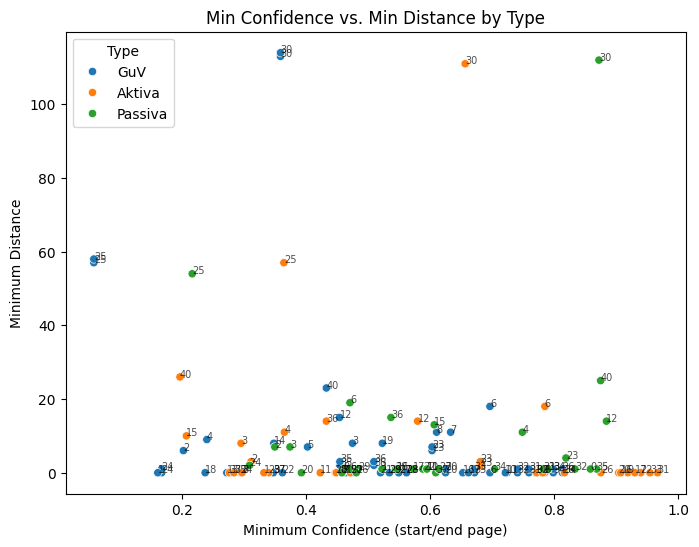

In [30]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the minimum confidence for each row
df_check["min_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].min(axis=1)
df_check["mean_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].mean(axis=1)
df_check["max_confidence"] = df_check[["confidence_start_page", "confidence_end_page"]].max(axis=1)
# Assign a unique integer to each unique filepath for annotation or coloring
df_check["path_id"] = df_check["filepath"].astype("category").cat.codes
df_check["min_confidence_path_group"] = df_check.groupby("path_id")["min_confidence"].transform("min")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

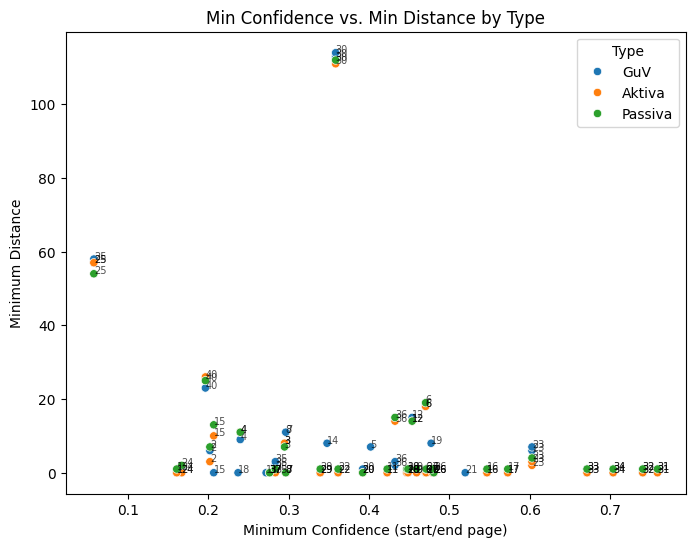

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_check,  # [~df_check["in_range"]],
    x="min_confidence_path_group",
    y="min_distance",
    hue="type",
    palette="tab10"
)

# Annotate each point with the last part of the filepath (e.g., filename)
for i, row in df_check.iterrows():
    plt.text(
        row["min_confidence_path_group"],
        row["min_distance"],
        str(row["path_id"]),  # or: os.path.basename(row["filepath"]) if you want the filename
        fontsize=7,
        alpha=0.7
    )
plt.xlabel("Minimum Confidence (start/end page)")
plt.ylabel("Minimum Distance")
plt.title("Min Confidence vs. Min Distance by Type")
plt.legend(title="Type")
plt.show()

<Axes: >

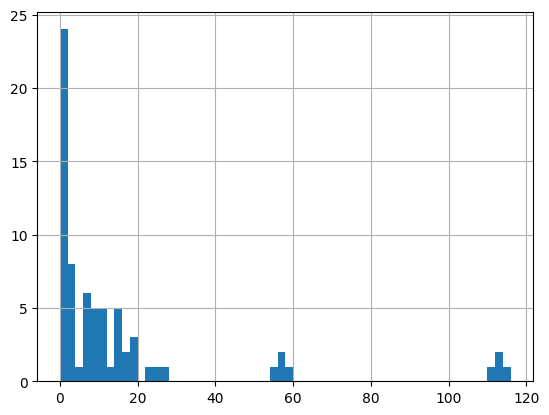

In [72]:
df_check[~df_check["in_range"]]["min_distance"].hist(bins=range(0, int(df_check["min_distance"].max()) + 3, 2))

In [74]:
df_check[df_check['min_distance']>80]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,118.0,GuV,5,5,0.416241,0.330158,False,113.0,0.330158,0.373199,0.416241,30,0.330158
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,119.0,GuV,5,5,0.416241,0.330158,False,114.0,0.330158,0.373199,0.416241,30,0.330158
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,116.0,Aktiva,5,5,0.656186,0.954893,False,111.0,0.656186,0.805539,0.954893,30,0.330158
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,117.0,Passiva,5,5,0.871736,0.997955,False,112.0,0.871736,0.934845,0.997955,30,0.330158


In [75]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf")]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
17,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,118.0,GuV,5,5,0.416241,0.330158,False,113.0,0.330158,0.373199,0.416241,30,0.330158
18,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,119.0,GuV,5,5,0.416241,0.330158,False,114.0,0.330158,0.373199,0.416241,30,0.330158
70,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,116.0,Aktiva,5,5,0.656186,0.954893,False,111.0,0.656186,0.805539,0.954893,30,0.330158
115,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,117.0,Passiva,5,5,0.871736,0.997955,False,112.0,0.871736,0.934845,0.997955,30,0.330158


In [76]:
df_check[(df_check['min_distance']<80) & (df_check['min_distance']>20)]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
23,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,68.0,GuV,10,11,0.055672,0.267806,False,57.0,0.055672,0.161739,0.267806,25,0.055672
24,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,69.0,GuV,10,11,0.055672,0.267806,False,58.0,0.055672,0.161739,0.267806,25,0.055672
49,../Geschaeftsberichte/degewo AG/212131_degewo_...,33.0,GuV,56,56,0.601634,0.420752,False,23.0,0.420752,0.511193,0.601634,40,0.196571
73,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,66.0,Aktiva,8,9,0.362866,0.818178,False,57.0,0.362866,0.590522,0.818178,25,0.055672
94,../Geschaeftsberichte/degewo AG/212131_degewo_...,30.0,Aktiva,56,56,0.196571,0.943644,False,26.0,0.196571,0.570107,0.943644,40,0.196571
118,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,67.0,Passiva,12,13,0.229301,0.945955,False,54.0,0.229301,0.587628,0.945955,25,0.055672
138,../Geschaeftsberichte/degewo AG/212131_degewo_...,31.0,Passiva,56,56,0.861833,0.993195,False,25.0,0.861833,0.927514,0.993195,40,0.196571


In [77]:
df_check.groupby("filepath").size()

filepath
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2014_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2016_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2018_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2019_BBB.pdf         3
../Geschaeftsberichte/Amt für Statistik Berlin-Brandenburg/AP_Geschaeftsbericht_DE_2023_BBB.pdf         3
../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf                  3
../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf                                     6
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_bf_s.pdf                                   3
../Geschaeftsberichte/Berlinovo/Finanzbericht_Berlinovo_2022_s.pdf                                      3
../Geschaeftsberichte/Berlinovo/berli

In [78]:
df_check[df_check['filepath'].str.contains("../Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf")]

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10.0,GuV,10,10,0.983680,0.696119,True,0.0,0.696119,0.839899,0.983680,6,0.470475
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28.0,GuV,10,10,0.983680,0.696119,False,18.0,0.696119,0.839899,0.983680,6,0.470475
60,../Geschaeftsberichte/Berliner Bäder Betriebe/...,7.0,Aktiva,7,7,0.784629,0.827446,True,0.0,0.784629,0.806037,0.827446,6,0.470475
61,../Geschaeftsberichte/Berliner Bäder Betriebe/...,25.0,Aktiva,7,7,0.784629,0.827446,False,18.0,0.784629,0.806037,0.827446,6,0.470475
105,../Geschaeftsberichte/Berliner Bäder Betriebe/...,8.0,Passiva,7,7,0.470475,0.911548,False,1.0,0.470475,0.691011,0.911548,6,0.470475
106,../Geschaeftsberichte/Berliner Bäder Betriebe/...,26.0,Passiva,7,7,0.470475,0.911548,False,19.0,0.470475,0.691011,0.911548,6,0.470475


In [79]:
[entry for entry in files_with_toc if "/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf" in entry["path"]]

[{'path': '/home/simon/Documents/data_science/Thesis/Geschaeftsberichte/Berliner Bäder Betriebe/GB_BBB_Infra_2023.pdf',
  'toc': [[1, 'Lagebericht', 5],
   [1, 'Bilanz', 7],
   [1, 'Gewinn- und Verlustrechnung', 10],
   [1, 'Anhang', 13],
   [1, 'Lagebericht ', 17],
   [1, 'Bilanz', 25],
   [1, 'Anhang', 31],
   [1, 'Anlagenspiegel', 39],
   [1, 'Bestätigungsvermerk', 42]],
  'n_entries': 9,
  'markdown_toc': '|   hierarchy_level | title                       |   page_number |   enumeration |\n|------------------:|:----------------------------|--------------:|--------------:|\n|                 1 | Lagebericht                 |             5 |             1 |\n|                 1 | Bilanz                      |             7 |             2 |\n|                 1 | Gewinn- und Verlustrechnung |            10 |             3 |\n|                 1 | Anhang                      |            13 |             4 |\n|                 1 | Lagebericht                 |            17 |         

In [116]:
df_multientries = pd.DataFrame(df_check.groupby("filepath").size(), columns=['count']).reset_index().query("count > 4").reset_index()
df_multientries

,index,filepath,count
0,6,../Geschaeftsberichte/Berliner Bäder Betriebe/...,6
1,23,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,5


In [117]:
df_check[~df_check['filepath'].isin(df_multientries['filepath'])].groupby("in_range").size()

in_range
False    86
True     52
dtype: int64

In [104]:
small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= 3]
small_toc

['../Geschaeftsberichte/IBB/ibb_geschaeftsbericht_2012.pdf',
 '../Geschaeftsberichte/Berlinovo/berlinovo_gb2019_s.pdf',
 '../Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf',
 '../Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf',
 '../Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzernabschluss-2023.pdf',
 '../Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf']

<Axes: xlabel='i'>

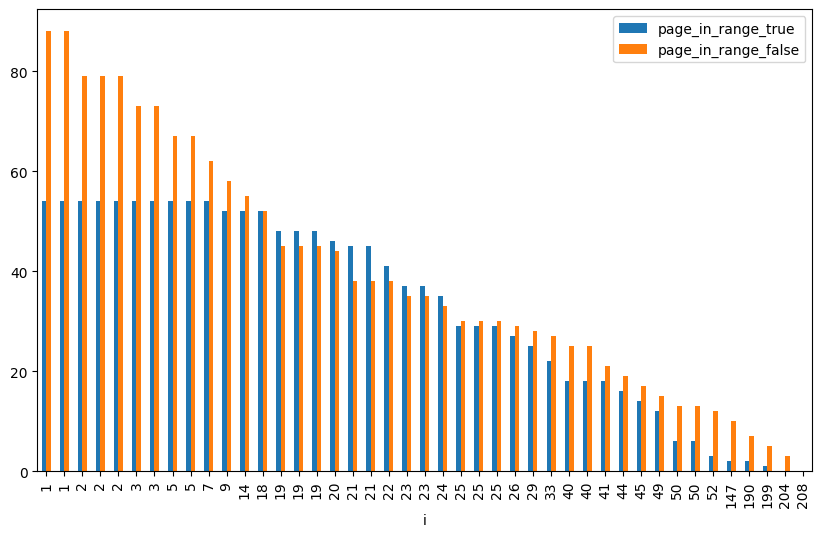

In [118]:
list = []

for i in [file['n_entries'] for file in files_with_toc]:
    small_toc = [file['path'].replace("/home/simon/Documents/data_science/Thesis", "..") for file in files_with_toc if file['n_entries'] <= i]
    page_in_range = df_check[~df_check['filepath'].isin(small_toc)].groupby("in_range").size()
    list.append({
        "i": i,
        "page_in_range_true": page_in_range.get(True, 0),
        "page_in_range_false": page_in_range.get(False, 0)
    })
    # print(f"i: {i}, page_in_range: {page_in_range}")

pd.DataFrame(list).sort_values(by="i", ascending=True).set_index("i").plot(kind="bar", figsize=(10, 6))

In [115]:
df_check

,filepath,page,type,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance,min_confidence,mean_confidence,max_confidence,path_id,min_confidence_path_group
0,../Geschaeftsberichte/Berliner Bäder Betriebe/...,10.0,GuV,10,10,0.983680,0.696119,True,0.0,0.696119,0.839899,0.983680,6,0.470475
1,../Geschaeftsberichte/Berliner Bäder Betriebe/...,28.0,GuV,10,10,0.983680,0.696119,False,18.0,0.696119,0.839899,0.983680,6,0.470475
2,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,44.0,GuV,44,44,0.948226,0.798095,True,0.0,0.798095,0.873160,0.948226,34,0.680419
3,../Geschaeftsberichte/IBB/ibb_geschaeftsberich...,45.0,GuV,44,44,0.948226,0.798095,False,1.0,0.798095,0.873160,0.948226,34,0.680419
4,../Geschaeftsberichte/IBB/ibb-jahresabschluss-...,6.0,GuV,6,6,0.985528,0.328488,True,0.0,0.328488,0.657008,0.985528,22,0.328488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,NaN,Passiva,45,47,0.559253,0.789411,False,NaN,0.559253,0.674332,0.789411,18,0.245531
145,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.518207,0.974258,False,1.0,0.518207,0.746232,0.974258,16,0.518207
146,../Geschaeftsberichte/GESOBAU AG/Gesch%C3%A4ft...,NaN,Passiva,39,41,0.873503,0.663166,False,NaN,0.663166,0.768335,0.873503,19,0.447945
147,../Geschaeftsberichte/GESOBAU AG/GESOBAU_Gesch...,41.0,Passiva,40,40,0.572712,0.970848,False,1.0,0.572712,0.771780,0.970848,17,0.572712


# TOC from text

In [1]:
import json


with open("../../Python/pdf_texts.json", "r") as f:
    data = json.load(f)

In [32]:
from pydantic import BaseModel

class TOC(BaseModel):
    toc: str

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'toc': {'title': 'Toc', 'type': 'string'}},
 'required': ['toc'],
 'title': 'TOC',
 'type': 'object'}

In [33]:
import re 

i = 5  # Number of pages to consider for the TOC

results = []
idx = 0

for key, value in data.items():
    idx += 1
    print(f"Processing file {idx}/{len(data)}: {key}")
    start_pages = "\n".join(value[0:5])
    start_pages = re.sub(r"(\.\s*){3,}", r"\.\.\.", start_pages)

    messages = [
        {"role": "system", "content": "[Role] You are a helpful assistant that can identify table of contents in a German financial report."},
        {"role": "system", "content": f"[Context] These are the text lines of the first {i} pages:\n\n{start_pages}"},
        {"role": "user", "content": f"[Tasks] 1. Please identify if there is a table of contents in the text."},
        {"role": "user", "content": f"2. If there is a table of contents, please extract its text."},
        {"role": "user", "content": f"3. Answer as JSON with the table of contents text as string in the key 'toc'."},
        {"role": "user", "content": f"If there is no table of contents, return an empty string."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
        max_tokens=5000,  # Increased to handle larger TOC responses
    )

    result = completion.choices[0].message.content
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        print(f"Error decoding JSON for file {key}: {result}")
        result_json = {"toc": result}
    result_json["file_path"] = key
    results.append(result_json)

Processing file 1/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf
Processing file 2/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf
Processing file 3/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf
Processing file 4/80: /pvc/Geschaeftsberichte/degewo AG/degewo_Konzernlagebericht_Konzernabschluss_2022.pdf
Error decoding JSON for file /pvc/Geschaeftsberichte/degewo AG/degewo_Konzernlagebericht_Konzernabschluss_2022.pdf: {
  "toc": "Konzernabschluss hr vom 1. Januar 2022 - 31. Dezember 2022\nKonzernlagebericht\n1. Grundlagen\n1.1\nDer degewo-Konzern (im Folgenden er. Als kommunales Unternehmen hat degewo den Auftrag, den Berliner Wohnungsmarkt positiv zu beeinflusDie Unternehmensstrategie zielt durch Investitionen in Neubau auf Wachstum ab.\nDie Beteiligungsstruktur der degewo Aktiengesellschaft besteht aus den bestandshaltenden Ob

In [34]:
results_toc_extraction = results
results_toc_extraction

[{'toc': 'Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht/.13\nJahresabschluss für das Geschäftsjahr vom 1. Januar bis 31. Dezember 2023/.1\n1. Bilanz zum 31. Dezember 2023/.3\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2023/.5\n3. Anhang für das Geschäftsjahr 2023/.1\nAnlagenspiegel/.11\nTätigkeitsabschlüsse/.1\nBESTÄTIGUNGSVERMERK DES UNABHÄNGIGEN ABSCHLUSSPRÜFERS/.1',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf'},
 {'toc': 'Inhaltsverzeichnis Seite\n\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht\n\n1. Bilanz zum 31. Dezember 2022\n\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2022\n\n3. Anhang für das Geschäftsjahr 2022\n\nAnlagenspiegel\n\nTätigkeitsabschlüsse\n\nBESTÄTIGUNGSVERMERK DES UNABHÄNGIGEN ABSCHLUSSPRÜFERS',
  'file_path': '/pvc/Geschaeftsberich

In [35]:
extracted_tocs = [r["toc"] for r in results_toc_extraction if r["toc"] != ""]
len(extracted_tocs)

66

## looping

In [36]:
import json
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()

page_range_result2 = []

for idx, entry in enumerate(r for r in results_toc_extraction if r["toc"] != ""):
    print(f"Processing file {idx + 1}/{len(extracted_tocs)}:")
    toc_string = entry["toc"]

    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        max_tokens=1000,
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["file_path"]
    result_json["toc"] = toc_string

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result2.append(result_json)


Processing file 1/66:
Processing file 2/66:
Processing file 3/66:
Processing file 4/66:
Processing file 5/66:
Processing file 6/66:
Processing file 7/66:
Processing file 8/66:
Processing file 9/66:
Processing file 10/66:
Processing file 11/66:
Processing file 12/66:
Processing file 13/66:
Processing file 14/66:
Processing file 15/66:
Processing file 16/66:
Processing file 17/66:
Processing file 18/66:
Processing file 19/66:
Processing file 20/66:
Processing file 21/66:
Processing file 22/66:
Processing file 23/66:
Processing file 24/66:
Processing file 25/66:
Processing file 26/66:
Processing file 27/66:
Processing file 28/66:
Processing file 29/66:
Processing file 30/66:
Processing file 31/66:
Processing file 32/66:
Processing file 33/66:
Processing file 34/66:
Processing file 35/66:
Processing file 36/66:
Processing file 37/66:
Processing file 38/66:
Processing file 39/66:
Processing file 40/66:
Processing file 41/66:
Processing file 42/66:
Processing file 43/66:
Processing file 44/6

In [37]:
page_range_result2

[{'GuV': {'start': 5, 'end': 5},
  'Aktiva': {'start': 3, 'end': 3},
  'Passiva': {'start': 3, 'end': 3},
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf',
  'toc': 'Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1. Erklärung zum Berliner Corporate Governance Kodex - Anlage zum Lagebericht/.13\nJahresabschluss für das Geschäftsjahr vom 1. Januar bis 31. Dezember 2023/.1\n1. Bilanz zum 31. Dezember 2023/.3\n2. Gewinn- und Verlustrechnung für die Zeit vom 1. Januar bis 31. Dezember 2023/.5\n3. Anhang für das Geschäftsjahr 2023/.1\nAnlagenspiegel/.11\nTätigkeitsabschlüsse/.1\nBESTÄTIGUNGSVERMERK DES UNABHÄNGIGEN ABSCHLUSSPRÜFERS/.1',
  'logprobs': {'GuV': [{'number': 5,
     'confidence': np.float64(0.9604852187288566)},
    {'number': 5, 'confidence': np.float64(0.7680738169790899)}],
   'Aktiva': [{'number': 3, 'confidence': np.float64(0.9632785304577033)},
    {'number': 3, 'confidence': np.float64(0.9433992485542445)}],
   'Passiva

In [38]:
import json

df_result2 = pd.DataFrame(page_range_result2)
df_result2['file_path'] = df_result2['file_path'].apply(lambda x: x.replace("/pvc/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long2 = df_result2.melt(id_vars=["file_path", "logprobs", "toc"], var_name="type", value_name="page_range")
df_long2["logprobs"] = df_long2.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long2["start_page"] = df_long2["page_range"].apply(lambda x: x["start"])
df_long2["end_page"] = df_long2["page_range"].apply(lambda x: x["end"])
df_long2 = df_long2.drop(columns=["page_range"])
df_long2.rename(columns={"file_path": "filepath"}, inplace=True)
df_long2["confidence_start_page"] = df_long2["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long2["confidence_end_page"] = df_long2["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long2 = df_long2.drop(columns=["logprobs"])

df_long2

,filepath,toc,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,GuV,5,5,0.960485,0.768074
1,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,GuV,2,2,0.640973,0.478503
2,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis,GuV,10,15,0.211534,0.513981
3,../Geschaeftsberichte/degewo AG/degewo_Konzern...,"{\n ""toc"": ""Konzernabschluss hr vom 1. Januar...",GuV,10,15,0.096292,0.193517
4,../Geschaeftsberichte/degewo AG/240618-degewo-...,Zusammengefasster Lagebericht\n1. Grundlagen\n...,GuV,10,15,0.178286,0.373326
...,...,...,...,...,...,...,...
193,../Geschaeftsberichte/Amt für Statistik Berlin...,Geschäftsbericht 2014 Inhaltsverzeichnis\n2 Vo...,Passiva,23,24,0.478477,0.956066
194,../Geschaeftsberichte/Amt für Statistik Berlin...,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,Passiva,7,8,0.488259,0.887483
195,../Geschaeftsberichte/Amt für Statistik Berlin...,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,Passiva,7,8,0.514302,0.848520
196,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,17,18,0.540010,0.947815


In [39]:
df_check2 = df.merge(df_long2, on=["filepath", "type"], how="right")
df_check2["in_range"] = df_check2.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check2['min_distance'] = df_check2.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check2

,filepath,page,type,toc,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance
0,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,5,5,0.960485,0.768074,False,18.0
1,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\n\nLagebericht/.1\n1....,5,5,0.960485,0.768074,False,38.0
2,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,2,2,0.640973,0.478503,False,21.0
3,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\n\n1. Erklärung zum B...,2,2,0.640973,0.478503,False,41.0
4,../Geschaeftsberichte/Berlin Energie und Netzh...,10.0,GuV,Inhaltsverzeichnis,10,15,0.211534,0.513981,True,0.0
...,...,...,...,...,...,...,...,...,...,...
228,../Geschaeftsberichte/Amt für Statistik Berlin...,25.0,Passiva,Geschäftsbericht 2014 Inhaltsverzeichnis\n2 Vo...,23,24,0.478477,0.956066,False,1.0
229,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,7,8,0.488259,0.887483,False,1.0
230,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2 Vorwort des Vorstandes\nOrganisation 4\n6 Bi...,7,8,0.514302,0.848520,False,1.0
231,../Geschaeftsberichte/Amt für Statistik Berlin...,19.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,17,18,0.540010,0.947815,False,1.0


In [40]:
df_check2.groupby("in_range").size()

in_range
False    202
True      31
dtype: int64

In [42]:
df_check2.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       64
         True         7
GuV      False       75
         True        17
Passiva  False       63
         True         7
dtype: int64

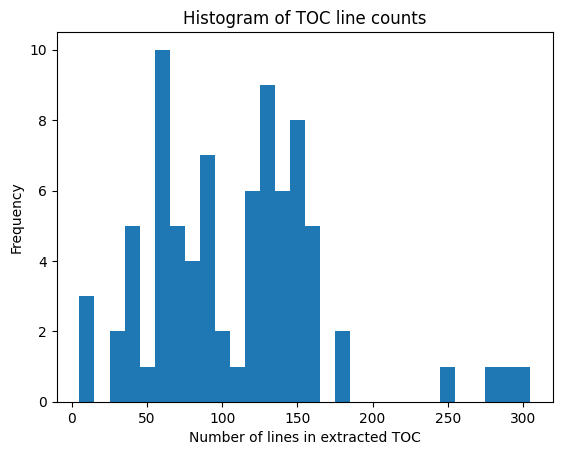

In [43]:
n_lines = [len("\n".join(value[0:5]).split("\n")) for key, value in data.items()]

import matplotlib.pyplot as plt

plt.hist(n_lines, bins=30)
plt.xlabel("Number of lines in extracted TOC")
plt.ylabel("Frequency")
plt.title("Histogram of TOC line counts")
plt.show()

# 200 lines approach

In [44]:
from pydantic import BaseModel

class TOC(BaseModel):
    toc: str

json_schema = TOC.model_json_schema()
json_schema

{'properties': {'toc': {'title': 'Toc', 'type': 'string'}},
 'required': ['toc'],
 'title': 'TOC',
 'type': 'object'}

In [45]:
import re 

results = []
idx = 0

for key, value in data.items():
    idx += 1
    print(f"Processing file {idx}/{len(data)}: {key}")
    start_pages = "\n".join("\n".join(value).split("\n")[:200])  # Take only the first 200 lines
    start_pages = re.sub(r"(\.\s*){3,}", r"\.\.\.", start_pages)

    messages = [
        {"role": "system", "content": "[Role] You are a helpful assistant that can identify table of contents in a German financial report."},
        {"role": "system", "content": f"[Context] These are the text lines of the first {i} pages:\n\n{start_pages}"},
        {"role": "user", "content": f"[Tasks] 1. Please identify if there is a table of contents in the text."},
        {"role": "user", "content": f"2. If there is a table of contents, please extract its text."},
        {"role": "user", "content": f"3. Answer as JSON with the table of contents text as string in the key 'toc'."},
        {"role": "user", "content": f"If there is no table of contents, return an empty string."},
    ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
        max_tokens=5000,  # Increased to handle larger TOC responses
    )

    result = completion.choices[0].message.content
    try:
        result_json = json.loads(result)
    except json.JSONDecodeError:
        print(f"Error decoding JSON for file {key}: {result}")
        result_json = {"toc": result}
    result_json["file_path"] = key
    results.append(result_json)

Processing file 1/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf
Processing file 2/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf
Processing file 3/80: /pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss_2021_BEN_GmbH.pdf
Processing file 4/80: /pvc/Geschaeftsberichte/degewo AG/degewo_Konzernlagebericht_Konzernabschluss_2022.pdf
Processing file 5/80: /pvc/Geschaeftsberichte/degewo AG/2017_degewo_degewo_Homepage.pdf
Processing file 6/80: /pvc/Geschaeftsberichte/degewo AG/201231_degewo_Konzernlagebericht_Konzernabschluss.pdf
Processing file 7/80: /pvc/Geschaeftsberichte/degewo AG/212131_degewo_2022_Konzernlagebericht_Konzernabschluss.pdf
Processing file 8/80: /pvc/Geschaeftsberichte/degewo AG/2019_degewo_Konzernbericht_und_Gleicher_Lohn_fuer_gleiche_Arbeit.pdf
Processing file 9/80: /pvc/Geschaeftsberichte/degewo AG/240618-degewo-konzernlagerbericht-konzern

In [46]:
results_toc_extraction2 = results
results_toc_extraction2

[{'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen \n2.2 Geschäftsverlauf \n2.3 Lage \nErtragslage \nVermögenslage \nFinanzlage \nChancen- und Risikobericht \nPrognosebericht',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf'},
 {'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen\n2.2 Geschäftsverlauf\n2.3 Lage\nErtragslage\nVermögenslage\nFinanzlage\nChancen- und Risikobericht\nPrognosebericht',
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/SIGNATURE_DEE00084236.1.1_550912_Endexemplar_20230331.pdf'},
 {'toc': 'Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBilanzierungs- und Bewertungsmethoden\nErläuterunge

In [48]:
extracted_tocs2 = [r["toc"] for r in results_toc_extraction2 if r["toc"] != ""]
len(extracted_tocs2)

71

## looping

In [49]:
import json
from pydantic import BaseModel

class PageRange(BaseModel):
    start: int
    end: int

class TOC(BaseModel):
    GuV: PageRange
    Aktiva: PageRange
    Passiva: PageRange

json_schema = TOC.model_json_schema()

page_range_result3 = []

for idx, entry in enumerate(r for r in results_toc_extraction2 if r["toc"] != ""):
    print(f"Processing file {idx + 1}/{len(extracted_tocs2)}:")
    # print(entry)
    toc_string = entry["toc"]


    messages = [
        {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
        {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
        {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (in German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
        {"role": "user", "content": f"The assets and liabilities are part of the balance sheet (in German: Bilanz). The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
        {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    ]
    
    # messages = [
    #     {"role": "system", "content": "You are a helpful assistant that can determine the page range information in a German financial report can be found at based on the documents table of contents."},
    #     {"role": "user", "content": f"This is the table of contents:\n\n{toc_string}"},
    #     {"role": "user", "content": f"On which pages might the win and loss statement (in German: Gewinn- und Verlustrechnung; GuV) and the balance sheets (German: Bilanz) be located? Give seperate answers for:\n\n1) the assets (German: Aktiva) table.\n2) the liabilities (German: Passiva) table.\n3) the win and loss statement."},
    #     {"role": "user", "content": f"The assets and liabilities tables often are on separate pages. They are often located directly before the win and loss statement. Rarely the tables for any of the three can span multiple pages."},
    #     {"role": "user", "content": f"Answer in JSON format with keys 'GuV', 'Aktiva', and 'Passiva' and the page range as values."},
    # ]

    completion = client.chat.completions.create(
        model=model,
        messages=combine_messages(messages),
        extra_body={
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "toc",
                    "schema": json_schema
                },
            },
        },
        logprobs=1,
        temperature=0,
    )

    result = completion.choices[0].message.content
    result_json = json.loads(result)
    result_json["file_path"] = entry["file_path"]
    result_json["toc"] = toc_string

    logprobs = getattr(completion.choices[0], "logprobs", None)
    digit_logprobs = calculate_confidence_for_integers(logprobs) if logprobs else None
    result_json["logprobs"] = {'GuV': digit_logprobs[0:2], 'Aktiva': digit_logprobs[2:4], 'Passiva': digit_logprobs[4:]}

    page_range_result3.append(result_json)


Processing file 1/71:
Processing file 2/71:
Processing file 3/71:
Processing file 4/71:
Processing file 5/71:
Processing file 6/71:
Processing file 7/71:
Processing file 8/71:
Processing file 9/71:
Processing file 10/71:
Processing file 11/71:
Processing file 12/71:
Processing file 13/71:
Processing file 14/71:
Processing file 15/71:
Processing file 16/71:
Processing file 17/71:
Processing file 18/71:
Processing file 19/71:
Processing file 20/71:
Processing file 21/71:
Processing file 22/71:
Processing file 23/71:
Processing file 24/71:
Processing file 25/71:
Processing file 26/71:
Processing file 27/71:
Processing file 28/71:
Processing file 29/71:
Processing file 30/71:
Processing file 31/71:
Processing file 32/71:
Processing file 33/71:
Processing file 34/71:
Processing file 35/71:
Processing file 36/71:
Processing file 37/71:
Processing file 38/71:
Processing file 39/71:
Processing file 40/71:
Processing file 41/71:
Processing file 42/71:
Processing file 43/71:
Processing file 44/7

In [50]:
page_range_result3

[{'GuV': {'start': 10, 'end': 15},
  'Aktiva': {'start': 8, 'end': 9},
  'Passiva': {'start': 10, 'end': 11},
  'file_path': '/pvc/Geschaeftsberichte/Berlin Energie und Netzholding/Jahresabschluss-BEN-GmbH-2023.pdf',
  'toc': 'Inhaltsverzeichnis Seite\nGrundlagen des Unternehmens \n1.1 Gesellschaftsrechtliche Struktur\n1.2 Ziele und Strategien \nWirtschaftsbericht \n2.1 Politische und wirtschaftliche Rahmenbedingungen \n2.2 Geschäftsverlauf \n2.3 Lage \nErtragslage \nVermögenslage \nFinanzlage \nChancen- und Risikobericht \nPrognosebericht',
  'logprobs': {'GuV': [{'number': 10,
     'confidence': np.float64(0.07525810384336475)},
    {'number': 15, 'confidence': np.float64(0.2876623207371536)}],
   'Aktiva': [{'number': 8, 'confidence': np.float64(0.3884259534647916)},
    {'number': 9, 'confidence': np.float64(0.8157291640646657)}],
   'Passiva': [{'number': 10, 'confidence': np.float64(0.2957093637542388)},
    {'number': 11, 'confidence': np.float64(0.8380292645220564)}]}},
 {'GuV'

In [51]:
import json

df_result3 = pd.DataFrame(page_range_result3)
df_result3['file_path'] = df_result3['file_path'].apply(lambda x: x.replace("/pvc/", "../"))  # Ensure file_path is string type
# Melt the DataFrame to long format, keeping 'file_path' as id
df_long3 = df_result3.melt(id_vars=["file_path", "logprobs", "toc"], var_name="type", value_name="page_range")
df_long3["logprobs"] = df_long3.apply(lambda x: x.get("logprobs").get(x["type"]) if x.get("logprobs") else None, axis=1)
# Convert the 'page_range' column from JSON string to dict if necessary

# If page_range is already a dict, this will do nothing; otherwise, it will parse the string
# df_long["page_range"] = df_long["page_range"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Split into two new columns
df_long3["start_page"] = df_long3["page_range"].apply(lambda x: x["start"])
df_long3["end_page"] = df_long3["page_range"].apply(lambda x: x["end"])
df_long3 = df_long3.drop(columns=["page_range"])
df_long3.rename(columns={"file_path": "filepath"}, inplace=True)
df_long3["confidence_start_page"] = df_long3["logprobs"].apply(lambda x: x[0].get("confidence") if x else None)
df_long3["confidence_end_page"] = df_long3["logprobs"].apply(lambda x: x[1].get("confidence") if x else None)
df_long3 = df_long3.drop(columns=["logprobs"])

df_long3

,filepath,toc,type,start_page,end_page,confidence_start_page,confidence_end_page
0,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,GuV,10,15,0.075258,0.287662
1,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,GuV,23,25,0.058729,0.139121
2,../Geschaeftsberichte/Berlin Energie und Netzh...,Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBi...,GuV,10,15,0.156792,0.402109
3,../Geschaeftsberichte/degewo AG/degewo_Konzern...,Konzernabschluss hr vom 1. Januar 2022 - 31. D...,GuV,10,15,0.229065,0.410207
4,../Geschaeftsberichte/degewo AG/240618-degewo-...,Zusammengefasster Lagebericht\n1. Grundlagen\n...,GuV,10,15,0.171209,0.383290
...,...,...,...,...,...,...,...
208,../Geschaeftsberichte/Amt für Statistik Berlin...,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,Passiva,7,8,0.515131,0.893157
209,../Geschaeftsberichte/Amt für Statistik Berlin...,2022\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,Passiva,7,8,0.515131,0.895672
210,../Geschaeftsberichte/Amt für Statistik Berlin...,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,Passiva,17,18,0.539808,0.944003
211,../Geschaeftsberichte/Amt für Statistik Berlin...,"{\n ""toc"": ""Inhaltsverzeichnis\n2 Vorwort des...",Passiva,24,24,0.891630,0.933904


In [52]:
df_check3 = df.merge(df_long3, on=["filepath", "type"], how="right")
df_check3["in_range"] = df_check3.apply(lambda row: row["start_page"] <= row["page"] <= row["end_page"], axis=1)
df_check3['min_distance'] = df_check3.apply(lambda row: min(abs(row["start_page"] - row["page"]), abs(row["end_page"] - row["page"])) if not row["in_range"] else 0, axis=1)

df_check3

,filepath,page,type,toc,start_page,end_page,confidence_start_page,confidence_end_page,in_range,min_distance
0,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,10,15,0.075258,0.287662,False,8.0
1,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,10,15,0.075258,0.287662,False,28.0
2,../Geschaeftsberichte/Berlin Energie und Netzh...,23.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,23,25,0.058729,0.139121,True,0.0
3,../Geschaeftsberichte/Berlin Energie und Netzh...,43.0,GuV,Inhaltsverzeichnis Seite\nGrundlagen des Unter...,23,25,0.058729,0.139121,False,18.0
4,../Geschaeftsberichte/Berlin Energie und Netzh...,10.0,GuV,Inhaltsverzeichnis\n\nAllgemeine Hinweise \nBi...,10,15,0.156792,0.402109,True,0.0
...,...,...,...,...,...,...,...,...,...,...
245,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2021\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,7,8,0.515131,0.893157,False,1.0
246,../Geschaeftsberichte/Amt für Statistik Berlin...,9.0,Passiva,2022\nGeschäftsbericht\nI\nM\nP\nR\nE\nS\nS\nU...,7,8,0.515131,0.895672,False,1.0
247,../Geschaeftsberichte/Amt für Statistik Berlin...,19.0,Passiva,Inhaltsverzeichnis\n2 Vorwort des Vorstandes\n...,17,18,0.539808,0.944003,False,1.0
248,../Geschaeftsberichte/Amt für Statistik Berlin...,27.0,Passiva,"{\n ""toc"": ""Inhaltsverzeichnis\n2 Vorwort des...",24,24,0.891630,0.933904,False,3.0


In [214]:
df_check3.groupby("in_range").size()

in_range
False    209
True      37
dtype: int64

In [53]:
df_check3.groupby(["type", "in_range"]).size()

type     in_range
Aktiva   False       67
         True         9
GuV      False       74
         True        25
Passiva  False       65
         True        10
dtype: int64

# Save results

In [76]:
toc_results = {
    "machine_readable_toc": df_check.to_dict(orient="records"),
    "toc_extraction_results_5_pages": df_check2.to_dict(orient="records"),
    "toc_extraction_results_200_lines": df_check3.to_dict(orient="records"),
}

with open("../../benchmark_results/page_identification/toc_results_mistral_8B_balance_details.json", "w") as f:
    json.dump(toc_results, f, indent=4)